# Recommendation Systems

We have seen how Recommender/Recommendation Systems have played an integral parts in the success of Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos), etc.  For Amazon, these systems bring more than 30% of their total revenues. For Netflix service, 75% of movies that people watch are based on some sort of recommendation.

> The goal of Recommendation Systems is to find what is likely to be of interest to the user. This enables organizations to offer a high level of personalization and customer-tailored services.

## Three Main Types

- non-personalized
- content-based
- collaborative filtering

### Non-Personalized Recommendations

![screenshot of youtube's homepage](images/youtube-nonpersonalizedrecommendations.png)

YouTube is notorious for putting non-personalized content on their homepage (although they tailor recommendations in other places)

These recommendations are based purely on the popularity of the item!

#### Advantages
- Super easy (computationally and for the user to understand)
- Items are usually popular for a reason
- No cold-start issue

#### Disadvantages
- Not personalized
- New items won’t gain traction

## Content-Based

![screenshot found online of someone's 'made for you' recommendations from spotify](images/spotify-contentrecommendations.png)

[Image Source](https://www.howtogeek.com/393291/already-a-spotify-fan-here-are-6-new-features-you-might-have-missed/)

Content-based recommendations are based on the properties/attributes of the items, where the items you've rated highly (or, in Spotify's case, listened to recently or often) are then compared against the properties/attributes of other items, and those items are then recommended if they're considered 'similar'.

What items are 'similar'? Depends on your similarity metric:

![similarity metrics comparison](images/similaritymetrics.png)

[Image Source: "What Similarity Metric Should You Use for Your Recommendation System?](https://medium.com/bag-of-words/what-similarity-metric-should-you-use-for-your-recommendation-system-b45eb7e6ebd0) <- useful reading!

Those are just 3 examples, there are others (Jaccard index, Euclidian similarity) - but the point is you take some mathematical understanding of the items and find which ones are 'nearby' in some sense.

#### Advantages:
- Easy and transparent
- No cold start issue
- Recommend items to users with unique tastes

#### Disadvantages:
- Requires some type of tagging of items
- Overspecialization to certain types of items

## Collaborative Filtering

![collaborative filtering utility matrix example](images/collaborativefiltering.png)

[Image Source](https://www.incubegroup.com/blog/recommender-system-for-private-banking/)

Use both User and Item data! Use past behavior of many users (how they've rated many items) to find similarities either between users or between items (either user-based or item-based) to recommend new things.

We build a Utility/Rating Matrix to capture many users' ratings of many different items - a matrix that, in practice, tends to be quite _sparse_ (see all the blanks in just this tiny example above).

Then, for _some_ models, we use **_MATH_** (namely, matrix factorization) to fill in those blanks, based upon similar users' ratings of similar items.

More specifically, it finds factor matrices which result in the ratings it has - decomposing the actual Utility Matrix into component pieces that explain it. These component pieces, matrices themselves, can be thought of as 'latent' or 'inherent' features of the items and users! The math then comes in, as we calculate the dot products in order to arrive at our predicted ratings.'

<img src="images/matrixfactorization.png" alt="matrix factorization image, showing the factor matrices" width=700>

[Image Source](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)

A bit more on Matrix Factorization, [Google's Recommendations Systems crash course](https://developers.google.com/machine-learning/recommendation/collaborative/matrix)

#### Advantages:
- Personalized. You’re special!

#### Disadvantages:
- Can require a lot of computation, especially as these matrices get larger
- Cold start: need to have a lot of ratings to be worthwhile
- Popularity Bias: biased towards items that are popular. May not capture people’s unique tastes.

Matrix factorization methods include Singular Value Decomposition (SVD) and Alternating Least Squares (ALS)

I'll note that there are differences between _explicit_ and _implicit_ ratings.

- **_Explicit_** data is gathered from users when we ask a user to rate an item on some scale
    - Pros: concrete rating system, can assume users actually feel the way they input and thus can extrapolate from those preferences
    - Cons: not all users might input their preferences
- **_Implicit_** data is gathered from users without their direct input - a system logs the actions of a user
    - Pros: Easier to collect automatically, thus have more data from more users without those users needing to go through extra steps
    - Cons: More difficult to work with - how do we know what actions imply preference?

[Resource](https://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/collaborativefiltering.html#:~:text=Implicit%20Data%20Collection,system%20has%20to%20collect%20data.&text=Explicit%20data%20gathering%20is%20easy,data%20to%20predict%20future%20ratings.)

## And now, in code!

### Reading in the data and simple EDA

#### Data Source:

https://www.kaggle.com/rounakbanik/the-movies-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
df = pd.read_csv('ratings.csv') 
print(df.shape) 
df.head(10) 

(100004, 4)


userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
5       1     1263     2.0  1260759151
6       1     1287     2.0  1260759187
7       1     1293     2.0  1260759148
8       1     1339     3.5  1260759125
9       1     1343     2.0  1260759131

### Ratings

In [3]:
ratings = df['rating'].value_counts()
ratings

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

In [4]:
ratings_sorted = dict(zip(ratings.index, ratings))

In [5]:
ratings_sorted

{4.0: 28750,
 3.0: 20064,
 5.0: 15095,
 3.5: 10538,
 4.5: 7723,
 2.0: 7271,
 2.5: 4449,
 1.0: 3326,
 1.5: 1687,
 0.5: 1101}

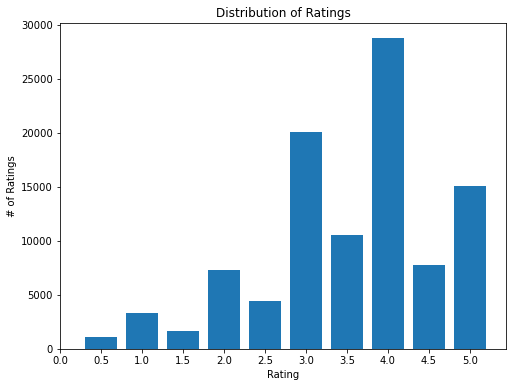

In [6]:
# plot distribution in matplotlib
plt.figure(figsize=(8,6))
plt.bar(ratings_sorted.keys(), ratings_sorted.values(), width=.4)
plt.xticks(np.arange(0, 5.1, step=0.5))
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

### Users

In [7]:
print("Number of users: ", df.userId.nunique()) 
print("Average Number of Reviews per User: ", df.shape[0]/df.userId.nunique())

Number of users:  671
Average Number of Reviews per User:  149.03725782414307


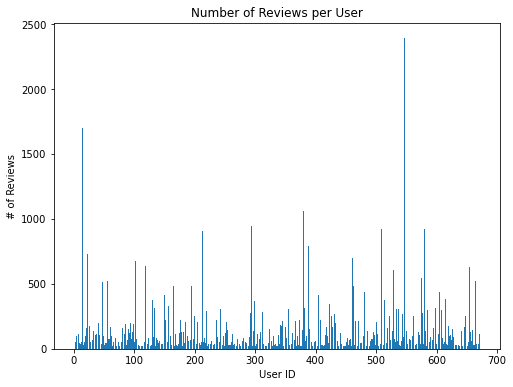

In [8]:
ratings_per_user = df['userId'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))

plt.figure(figsize=(8,6))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user])
plt.xlabel("User ID")
plt.ylabel("# of Reviews")
plt.title("Number of Reviews per User")
plt.show()

### Movies

In [9]:
print("Number of movies: ", df.movieId.nunique())
print("Average Number of Reviews per Movie: ", df.shape[0]/df.movieId.nunique())

Number of movies:  9066
Average Number of Reviews per Movie:  11.030664019413193


In [10]:
# the movie IDs with the most ratings
df['movieId'].value_counts()[:10]

356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
Name: movieId, dtype: int64

In [11]:
df['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
48520       1
111913      1
1311        1
27922       1
2049        1
Name: movieId, Length: 9066, dtype: int64

LOTS OF MOVIES WITH ONE RATING

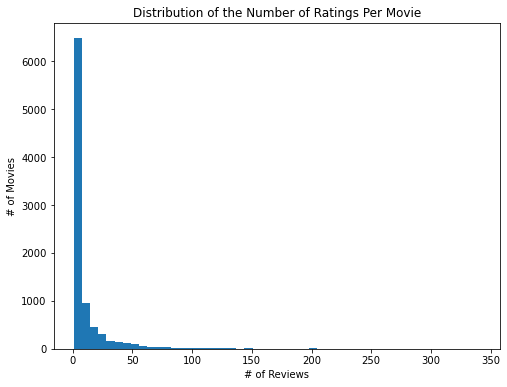

In [12]:
ratings_per_movie = df['movieId'].value_counts()

plt.figure(figsize=(8, 6))
plt.hist(ratings_per_movie, bins=50)
plt.xlabel("# of Reviews")
plt.ylabel("# of Movies")
plt.title("Distribution of the Number of Ratings Per Movie")
plt.show()

## Fitting Recommendation System Models

One of the easiest libraries to use for recommendation systems is Surprise.

Surprise has some basic algorithms - like `BaselineOnly` ([documentation](https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly)), which predicts a baseline estimate for a given user an item.

In [18]:
# Uncomment and run the line below if surprise is not installed:
# !pip install surprise -q

# Standard Surprise Imports
from surprise import Dataset, Reader

# Surprise Models
from surprise import BaselineOnly, SVD, KNNBasic

# Surprise Metrics
from surprise import accuracy

# Surprise Model Evaluation
from surprise.model_selection import cross_validate, train_test_split

### Task 1 - Create a Surprise Dataset

In the cell below, 
- Isolate the `userId`, `movieId`, and `rating`, columns. 
- Store a dataframe with those three columns in the variable `data`.
- Read in the data variable, using Surprise `Dataset`.

In [19]:
df[['userId', 'movieId', 'rating']]

userId  movieId  rating
0            1       31     2.5
1            1     1029     3.0
2            1     1061     3.0
3            1     1129     2.0
4            1     1172     4.0
...        ...      ...     ...
99999      671     6268     2.5
100000     671     6269     4.0
100001     671     6365     4.0
100002     671     6385     2.5
100003     671     6565     3.5

[100004 rows x 3 columns]

In [20]:
data = df[['userId', 'movieId', 'rating']]

In [21]:
# Pass data to Dataset object to reformat data so that later models can understand it
# It handles issues of sparsity for us
# number of users = 671; number of items = 9066
# users < items, therefore set users as rows (allows model to run faster)
# csv = comma-separated values; therefore sep is a comma

reader = Reader(line_format = 'user item rating', sep = ',')
data = Dataset.load_from_df(data, reader = reader)

### Task 2 - Cross Validate a Model

In the cell below,

- Create an instance of a `BaselineOnly` model.
    - Set the variable name to `baseline`.
- Pass the baseline model into Surprise's `cross_validate` function.
    - Set verbose to `True`
    - Save the output to the variable `baseline_metrics`.

In [22]:
# BaselineOnly essentially predicts average rating for a user
baseline = BaselineOnly()
baseline_metrics = cross_validate(baseline, data, verbose = True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8862  0.8914  0.9001  0.8938  0.8951  0.8933  0.0046  
MAE (testset)     0.6851  0.6881  0.6959  0.6900  0.6926  0.6903  0.0037  
Fit time          0.17    0.18    0.18    0.18    0.18    0.18    0.00    
Test time         0.10    0.06    0.06    0.10    0.10    0.08    0.02    


In [ ]:
# Setting verbose = True provides table at end identifying RMSE for each fold, etc.

**Let's take a look at `baseline_metrics`.**

In [23]:
# provides info in table stored as dictionary
baseline_metrics

{'test_rmse': array([0.88615489, 0.89140507, 0.90009558, 0.89379407, 0.89511508]),
 'test_mae': array([0.68507434, 0.68810594, 0.69585436, 0.69004378, 0.69264758]),
 'fit_time': (0.1699669361114502,
  0.1770617961883545,
  0.1810150146484375,
  0.17721199989318848,
  0.17879199981689453),
 'test_time': (0.1035909652709961,
  0.059632062911987305,
  0.06177997589111328,
  0.09694099426269531,
  0.0979452133178711)}

### Task 3 - Calculate Metrics

Calculate the average **root mean squared error** (rmse) and **mean absolute error** (mae). for the baseline model.
- Store the averages in a tuple called `baseline_error` with the following format:
    - ```(rmse, mae)```

In [24]:
# YOUR CODE HERE
baseline_metrics['test_rmse']

array([0.88615489, 0.89140507, 0.90009558, 0.89379407, 0.89511508])

In [25]:
baseline_metrics['test_rmse'].mean()

0.8933129377194613

In [26]:
rmse = baseline_metrics['test_rmse'].mean()
mae = baseline_metrics['test_mae'].mean()

baseline_error = (rmse, mae)
baseline_error
# Store baseline_error for later use

(0.8933129377194613, 0.6903452003880912)

### Task 4 - Fit a KNN Basic Model

In the cell below,

- Create an instance of the `KNNBasic` class
    - Set the instance to the variable `knn_basic`
- Cross validate the model
    - Set the output to `knn_basic_metrics`

In [27]:
# YOUR CODE HERE
# k is the main hyperparameter
# As we increase k, add bias to the model
# As we lower k, we increase variance
knn_basic = KNNBasic()

knn_basic_metric = cross_validate(knn_basic, data, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9633  0.9654  0.9698  0.9648  0.9776  0.9682  0.0052  
MAE (testset)     0.7410  0.7430  0.7448  0.7411  0.7495  0.7439  0.0031  
Fit time          0.07    0.10    0.09    0.09    0.09    0.09    0.01    
Test time         1.05    1.07    1.06    1.08    1.06    1.07    0.01    


In [ ]:
# If have lots of data, may not be able to fit a knn model (will crash the system)
# knn is a "memory-based model" because it is creating a graph 
# that is mapping the distance between every single observation with every single observation
# Therefore may cause kernel to crash if there is a ton of data


### Task 5 - Fit another Surprise KNN Model

- [Surprise KNN Documentation](https://surprise.readthedocs.io/en/stable/knn_inspired.html)

In [28]:
# Your code here
# Try KNNWithMeans

from surprise.prediction_algorithms.knns import KNNWithMeans

knn_means = KNNWithMeans()

knn_means_metrics = cross_validate(knn_means, data, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9154  0.9195  0.9208  0.9197  0.9188  0.9188  0.0018  
MAE (testset)     0.7032  0.7032  0.7047  0.7033  0.7040  0.7037  0.0006  
Fit time          0.09    0.11    0.11    0.11    0.11    0.11    0.01    
Test time         1.14    1.17    1.21    1.15    1.13    1.16    0.03    


### Task 6 - Create a train test split

In [29]:
# YOUR CODE HERE
# Most recommendation systems have enough data to support just using cross-validation 
# rather than using train-test-split

trainset, testset = train_test_split(data, test_size = 0.25)

### Task 7 - Fit Singular Value Decomposition (SVD) Model.
> [Surprise SVD Documentation](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)


In the cell below,

- Create an instance of the `SVD` class
    - Set the variable name to `svd`
- Fit the model to the training data

In [30]:
# YOUR CODE HERE
# SVD Models (i.e., matrix factorization-based algorithms) are useful if memory-based models are not an option
# SVD is worth gridsearching (namely, n_factors because there is 
# no way to know how many latent features are going to be most successful for your data)

svd = SVD()
svd.fit(trainset)

### Task 8 - Calculate the test metrics

In the cell below,
- Generate predictions for the test data.
- Calculate RMSE and MAE
    - Store the error in a tuple called `svd_error` with the following format
        - `(rmse, mae)`


In [33]:
# YOUR CODE HERE
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

svd_error = (rmse, mae)

RMSE: 0.8964
MAE:  0.6930


### Let's look at predictions for a second:

In [27]:
predictions[:10]

[Prediction(uid=624, iid=4816, r_ui=3.0, est=2.813705502680129, details={'was_impossible': False}),
 Prediction(uid=41, iid=6316, r_ui=4.5, est=3.861208011964106, details={'was_impossible': False}),
 Prediction(uid=316, iid=4643, r_ui=3.0, est=2.92455495961209, details={'was_impossible': False}),
 Prediction(uid=156, iid=3101, r_ui=4.5, est=4.192841048775028, details={'was_impossible': False}),
 Prediction(uid=533, iid=3528, r_ui=3.0, est=2.709866006026254, details={'was_impossible': False}),
 Prediction(uid=311, iid=8636, r_ui=4.5, est=3.292314610781932, details={'was_impossible': False}),
 Prediction(uid=39, iid=73, r_ui=3.0, est=4.115375267548529, details={'was_impossible': False}),
 Prediction(uid=435, iid=750, r_ui=5.0, est=4.294558408988318, details={'was_impossible': False}),
 Prediction(uid=475, iid=7458, r_ui=2.0, est=3.115377543270265, details={'was_impossible': False}),
 Prediction(uid=7, iid=1307, r_ui=3.0, est=3.751755483463596, details={'was_impossible': False})]

In [30]:
# Output with capitalized word followed by parenthesis with data contained indicates that it's an class
# Info within parenthesis are attributes of the class
# To access data within parenthesis, call attributes
# uid is user ID; iid is item ID
# r_ui is actual rating for user and item, est = predicted rating for user and item
predictions[0]

Prediction(uid=624, iid=4816, r_ui=3.0, est=2.813705502680129, details={'was_impossible': False})

In [32]:
predictions[0].uid

624

In [33]:
print("Number of users: ", df.userId.nunique()) 
print("Number of movies: ", df.movieId.nunique()) 

Number of users:  671
Number of movies:  9066


In [34]:
# If want to get a prediction for a specific user and a specific item:
user = 5
item = 141
svd.predict(user, item)

Prediction(uid=5, iid=141, r_ui=None, est=3.754177697480679, details={'was_impossible': False})

In [35]:
# In practice, for each user, will find est for all items.
# Items with highest est will be recommended to user.

### Grid Search

In [36]:
from surprise.model_selection import GridSearchCV

params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD ,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)